In [ ]:
# finetuning llama2

# (Q)分子構造+(R)理由+(A)物性データセットのLLMによる学習と予測
- Q&A: 融点データセットを使用
- R: GPT4を使い､Q&Aをもとに自動生成
- 強化学習をしてみる

In [ ]:
#!pip install transformers==4.35.0
#!pip install peft==0.5.0
#!pip install bitsandbytes==0.41.1
#!pip install accelerate==0.23.0
#!pip install flash-attn==2.3.1.post1
#!pip install datasets==2.14.5

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from transformers import AutoModelForCausalLM, BitsAndBytesConfig
import torch
from peft import LoraConfig, get_peft_model
from transformers import AutoTokenizer,pipeline
from datasets import Dataset
import copy
from tqdm import tqdm
#問題設定: はじめのN件をテストデータにする
n_test=50

/home/setup/miniconda3/envs/chemllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#ハイパラ関連
#モデル名
model_size=7
#model_size=13
#model_size=70
model_name=f"meta-llama/Llama-2-{model_size}b-chat-hf"

#LoRA関連
r=32
lora_alpha=r
bit=16
#bit=8
#bit=4

#LoRAのadapter
target_modules= [
    #"embed_tokens",
    "lm_head",
    #"q_proj",
    #"k_proj",
    "v_proj",
    "o_proj",
    "gate_proj",
    "up_proj",
    #"down_proj",
]

#学習関連
#gradient_checkpointing =True  #vramの節約をしたい場合
gradient_checkpointing =False
per_device_train_batch_size=1
epochs=3
lr=10**-5
do_train=True
#do_train=False

In [3]:

device_map="auto"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

def init_model(model_name, r, lora_alpha, target_modules, bit=4):
    if bit == 4:
        print("Using 4-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     quantization_config=bnb_config,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 8:
        print("Using 8-bit mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     load_in_8bit=True,
                                                     device_map=device_map,
                                                     use_flash_attention_2=True,
                                                     )
    elif bit == 16:
        print("Using fp16 mode")
        model = AutoModelForCausalLM.from_pretrained(model_name,
                                                     device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                     )
    else:
        raise ValueError("bit must be 4 or 16")

    if len(target_modules)==0:
        return model
    peft_config = LoraConfig(
        task_type="CAUSAL_LM", inference_mode=False, r=r, lora_alpha=lora_alpha,
        lora_dropout=0.1,
        target_modules=target_modules,
    )
    model = get_peft_model(model, peft_config)
    return model


In [4]:

#モデル初期化
model=init_model(model_name, r, lora_alpha, target_modules, bit=bit)

Using fp16 mode


Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


In [5]:


tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

#pipe = pipeline("text-generation", model=model,
#                tokenizer=tokenizer, max_new_tokens=1000)

# データセットの生成

In [6]:
#データセットの読み込み
import pandas as pd
import random
df=pd.read_csv("dataset/231225AutoReasoning/240104best_reason_record.csv")
dataset=df.to_dict(orient="records")
random.seed(0)
random.shuffle(dataset)

print(df.shape)
df[:2]

(2406, 9)


,name,smiles,csid,link,source,Reason,mpC,Prediction(integer),Abs error
0,"2,3-dibromo-2-methyl-butane",BrC(C)(C)C(Br)C,71392,http://www.srcinc.com/what-we-do/product.aspx?...,PHYSPROP,"Starting with butane, which melts around -138....",7.0,6.6,0.4
1,5-chlorobenzofuroxan,c1cc2c(cc1Cl)no[n+]2[O-],123661,http://www.alfa.com/en/GP100W.pgm?DSSTK=A14261,Alfa Aesar,"The basic structure for comparison is benzene,...",47.0,45.0,2.0


In [7]:
import random
system_prompt="You are a professional chemist. Predict the melting point of the following compound."


def gen_compound_text(chemical_record,
    reason="",prediction=""):
    name=chemical_record["name"]
    smiles=chemical_record["smiles"]
    prompt=f"""
#Problem
##Name: {name}
##SMILES: {smiles}"""
    if reason !="" and prediction!="":
        prompt+=f"""
##Reason: {reason}
##Prediction: {prediction}
"""
    else:
        #test mode
        prompt+="""
##Reason: 
"""
    return prompt



def generate_question_prompt(dataset,test_id,n_prompt_examples=5):
    train_ids=[i for i in range(len(dataset))]
    train_ids.remove(test_id)
    prompt=""

    #train prompt
    for _ in range(n_prompt_examples):
        id=random.choice(train_ids)
        prompt+=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
        prompt+="\n"

    #test prompt
    prompt+=gen_compound_text(dataset[test_id])

    return prompt


def prepare_dataset(context_list, tokenizer):
    data_list = [{"text": i} for i in context_list]
    random.shuffle(data_list)

    # tokenize
    dataset = Dataset.from_dict(
        {"text": [item["text"] for item in data_list[:]]})
    dataset = dataset.map(lambda samples: tokenizer(
        samples['text']), batched=True)

    return dataset


In [8]:


train_text_list=[]
for id in range(len(dataset)):
    prompt=gen_compound_text(dataset[id],
                                reason=dataset[id]["Reason"],
                                prediction=dataset[id]["Prediction(integer)"])
    train_text_list.append(prompt)
tokenized_dataset = prepare_dataset(train_text_list[n_test:], tokenizer)

Map:   0%|          | 0/2356 [00:00<?, ? examples/s]

Map: 100%|██████████| 2356/2356 [00:00<00:00, 8706.92 examples/s]


In [9]:
#check prompt

print("train")
print(prompt)
print("test")
t_prompt=gen_compound_text(dataset[0])
print(t_prompt)

train

#Problem
##Name: 2-Ethoxy-2-methylpropane
##SMILES: CC(C)(C)OCC
##Reason: The target compound, 2-Ethoxy-2-methylpropane, can be seen as derived from propane, which has a melting point of -187.7°C. Adding a methyl group generally increases the melting point due to increased molecular weight and van der Waals forces. For propane, adding a methyl group to become isobutane elevates the melting point to -159.6°C, indicating the effect of a methyl group is an increase of roughly +28°C. The presence of an ethoxy group (-OCC2H5) introduces an oxygen atom which can lead to dipole-dipole interactions and potential hydrogen bonding with trace moisture, increasing the melting point as well. The ethoxy group's effect on the melting point would be less straightforward to quantify without empirical data, but we can predict that it will raise the melting point to some extent. Considering the combined effect of an additional methyl group and an ethoxy group on the basic structure of propane, we 

# モデルの訓練

In [10]:
import transformers
from datetime import datetime


#train
train_args = transformers.TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        #gradient_accumulation_steps=1,
        warmup_steps=0,
        num_train_epochs=epochs,
        learning_rate=lr,
        fp16=True,
        logging_steps=100,
        save_total_limit=1,
        output_dir='outputs/'+datetime.now().strftime('%Y%m%d%H%M%S'),
        gradient_checkpointing=gradient_checkpointing,
    )

# trainer
#callbacks = [EarlyStoppingCallback()]
callbacks = []

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_dataset,
    args=train_args,
    callbacks=callbacks,
    data_collator=transformers.DataCollatorForLanguageModeling(
        tokenizer, mlm=False)
)

if do_train:
    training_result = trainer.train()
    training_result.training_loss

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
100,1.766400
200,1.360100
300,1.247600
400,1.172300
500,1.156500
600,1.127200
700,1.095300
800,1.104400
900,1.089200
1000,1.075100


In [9]:
#モデルの保存: adapterのみ保存するとき｡
from datetime import datetime
current_datetime = datetime.now()
#model.save_pretrained(f"./outputs/{current_datetime}")
#model.save_pretrained(f"./outputs/7b_ft")

In [10]:
#モデルの読み込み: 強化学習しない場合
from peft import AutoPeftModelForCausalLM
model_path="./outputs/7b_ft"

"""
model = AutoPeftModelForCausalLM.from_pretrained(model_path,
                                                 device_map=device_map,
                                                     torch_dtype=torch.float16,
                                                     use_flash_attention_2=True,
                                                 )

"""

'\nmodel = AutoPeftModelForCausalLM.from_pretrained(model_path,\n                                                 device_map=device_map,\n                                                     torch_dtype=torch.float16,\n                                                     use_flash_attention_2=True,\n                                                 )\n\n'

In [11]:
#モデルのマージと保存: 強化学習するとき
#merged_model = model.merge_and_unload()
#merged_model.save_pretrained(f"./outputs/7b_ft_merge")

# 強化学習による追加訓練

In [10]:
#予測周りのutility funcs
import re
import torch
import gc
from IPython.display import clear_output
from trl import AutoModelForCausalLMWithValueHead
def gen_text_stop_word(prompt,model,tokenizer,
                       device="cuda:0",
                       stop_words=["#Problem","#Reason","# Problem"],
                       double_stop_words=["#Prediction"],
                       stream=False,
                       #stream=True,
                       max_tokens=400,
                       ):
    gc.collect()
    torch.cuda.empty_cache()



    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    # 生成されたテキストを格納する変数
    generated_text = ""

    # トークンを一つずつ生成
    for i in range(max_tokens):
        # 次のトークンを予測
        outputs = model(input_ids)
        if type(model) is AutoModelForCausalLMWithValueHead:
            #AutoModelForCausalLMWithValueHeadの場合
            logits = outputs[0]
            next_token_logits = logits[:, -1, :]
        else:
            next_token_logits = outputs.logits[:, -1, :]

        next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

        # 生成されたトークンを現在の入力に追加
        input_ids = torch.cat([input_ids, next_token], dim=-1)

        # 生成されたテキストを更新
        generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)[len(prompt):]

        if stream:
            if i%30==0:
                clear_output()
            print(generated_text)

        # ストップワードのチェック
        if any(stop_word in generated_text for stop_word in stop_words):
            break

        # 2回以上出現したらstopするwordのcheck 
        stop_flag=False
        for check_word in double_stop_words:
            count=generated_text.count(check_word)
            if count>=2:
                stop_flag=True
                break
        if stop_flag:
            break

    return generated_text

def ask_value(prompt,model,tokenizer):
    res=gen_text_stop_word(prompt,model,tokenizer)
    #res=pipe(prompt)[0]["generated_text"]
    print("----\n\n")
    print(res.strip())

    regex_list=[
        r"Prediction:\s*(\d+\.?\d*)",
        r"Prediction:\s*(-?\d+\.?\d*)",
    ]

    value=None
    for reg in regex_list:
        match = re.search(reg, res)
        if match:
            value = match.group(1)
            break


    return res,value



In [11]:
from trl import PPOTrainer, PPOConfig


#テキストでファインチューニングしたモデルを強化学習用に読み込み

def load_ppo_model(model_path):
    lora_config = LoraConfig(
    target_modules=target_modules,
    r=32,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    )
    model = AutoModelForCausalLMWithValueHead.from_pretrained(
        model_path,
        #load_in_8bit=True,
        torch_dtype=torch.float16,
        device_map=device_map,
        peft_config=lora_config,
    )
    return model

def init_ppo_trainer(model,tokenizer):

    #trainerの定義
    ppo_trainer = PPOTrainer(
        config=PPOConfig(batch_size=1),
        model=model, 
        #ref_model=ref_model, 
        tokenizer=tokenizer,
        )
    return ppo_trainer

def reload_ppo_model_and_trainer(model,ppo_trainer,temp_dir="outputs/temp"):

    model.save_pretrained(temp_dir)

    model=None
    ppo_trainer=None
    print("clearing memory...")
    gc.collect()
    torch.cuda.empty_cache()

    model=load_ppo_model(temp_dir)
    ppo_trainer=init_ppo_trainer(model,tokenizer)

    return model,ppo_trainer


In [18]:
#model_path="./outputs/13b_ft_merge_3epoch"
model_path="./outputs/7b_ft_merge_3epoch"
temp_dir="outputs/temp"

#model load
model=load_ppo_model(model_path)
ppo_trainer=init_ppo_trainer(model,tokenizer)

#lora modelとして読み込み直す(vramの節約のため)
model,ppo_trainer=reload_ppo_model_and_trainer(model,ppo_trainer)

Loading checkpoint shards: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]
/home/setup/miniconda3/envs/chemllm/lib/python3.10/site-packages/trl/trainer/ppo_trainer.py:257: UserWarning: No dataset is provided. Make sure to set config.batch_size to the correct value before training.
  warnings.warn(


In [19]:
reward_model=None
gc.collect()
torch.cuda.empty_cache()


In [81]:
#報酬クラスの定義
class RewardModel:
    def __init__(self,model,dataset,tokenizer,
                 range_value=1,
                 reward_slope=50,
                 n_prompt_examples=3,
                 device="cuda:0",
                 ):
        self.model=model
        self.dataset=dataset
        self.tokenizer=tokenizer    
        self.n_prompt_examples=n_prompt_examples
        self.range_value = range_value
        self.reward_slope = reward_slope
        self.device=device

    def calculate_reward(self,abs_error, ):
        """
        Calculate the reward based on the absolute error.

        :param abs_error: The absolute error value.
        :param range_value: The range value for maximum and minimum rewards.
        :return: The calculated reward.
        """

        reward = self.range_value - (abs_error) * (self.range_value / self.reward_slope)
        return max(reward, -self.range_value)


    def __call__(self,train_id):
        prompt=generate_question_prompt(self.dataset,train_id,
                                        n_prompt_examples=self.n_prompt_examples)
        reason,value=ask_value(prompt,self.model,self.tokenizer,
                                         )

        actual=self.dataset[train_id]["mpC"]
        if value is None:
            reward=-self.range_value
        else:
            value=float(value)

            abs_error=abs(actual-value)
            # Example usage of the function
            reward=self.calculate_reward(abs_error)  # Example case where abs_error is 12 and range_value is 100

        #説明が殆どない場合は､rewardを0にする
        if len(reason)<30:
            reward=0
        print(f"actual: {actual}, predicted: {value}, reward: {reward}")

        input_ids = tokenizer.encode(prompt, return_tensors='pt').to(self.device)
        return reward,reason,input_ids


In [82]:

reward_model = RewardModel(model,dataset,tokenizer)
reward_model.calculate_reward(10)  #報酬の動作確認

0.8

In [83]:
import time
import warnings
warnings.filterwarnings('ignore')
#model.config.use_cache = False 
#model.config.use_cache = True
lr_epochs=250
#lr_epochs=3

n_iterations=0

for i in tqdm(range(lr_epochs)):
   #ランダムに問題を設定して値を予測させる
    train_id=random.randint(n_test,len(dataset))

    
    #このクラスにgpu cacheが残りがちなので､毎回初期化してメモリ開放しておく
    reward_model=None
    gc.collect()
    torch.cuda.empty_cache()
    reward_model = RewardModel(model,dataset,tokenizer)


    #同じ問題に対して､良い結果が来るまで何回か問題を解かせる
    for i in range(2):
        try:
            #報酬､応答､入力の取得
            reward,response,input_id=reward_model(train_id)
            rewards=[torch.tensor(float(reward))]
            query_tensors = [torch.tensor(input_id).reshape(-1)]
            response_tensors=[torch.tensor(tokenizer.encode(response)).reshape(-1)]

            #モデル更新
            stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
            n_iterations+=1
        except Exception as e:
            #主にcuda out of memoryが起きるので､一旦メモリ開放して､model類を読み込み直す
            print(e)
            model,ppo_trainer=reload_ppo_model_and_trainer(model,ppo_trainer)

            break

        #結果がよかったら次の問題に移る
        if reward>0.5:
            break

n_iterations

  0%|          | 0/250 [00:00<?, ?it/s]

----


- Base structure, benzene, has a melting point of 5.5°C. 
- Ketone group (C=O): +40°C, due to the polar nature and the ability to form dipole-dipole interactions. 
- Methyl group: +5°C, due to an increase in molecular weight and van der Waals forces. 
- Semicarbazone group: +80°C, due to the ability to form strong hydrogen bonds and the rigidity it introduces to the molecule. 
The sum of these effects gives us a predicted melting point of 130.5°C.
##Prediction: 130.5
actual: 136.0, predicted: 130.5, reward: 0.89


  0%|          | 1/250 [01:47<7:24:15, 107.05s/it]

----


- Basic unit, naphthalene, has a melting point of 80°C.
- The presence of a ketone group (C=O) can increase the melting point due to polarity and dipole-dipole interactions, let's estimate an increase of +20°C.
- The presence of a hydroxyl group (OH) can lead to hydrogen bonding, which usually has a significant effect on increasing the melting point, approximately +40°C in the context of naphthalene derivatives due to hydrogen bonding.
- The molecule has a complex structure with multiple rings and substituents, which can significantly increase the melting point due to increased molecular weight and van der Waals interactions. However, since this is already accounted for in the base value of naphthalene, we will not add any additional increase.
- The presence of an ether linkage (OC) can increase the melting point due to the polarity it introduces, let's estimate an increase of +5°C.

Summing these contributions gives us a total estimated increase from the base value of naphthale

In [ ]:
from datetime import datetime
#AutoModelForCausalLMWithValueHead classはdirを作っておかないと､save_pretrainedが動かない
current_datetime = datetime.now()
model_save_path=f"outputs/ppo{current_datetime}"
os.mkdir(model_save_path)
model.save_pretrained(model_save_path)

# モデルによる物性値の予測

In [12]:

model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaFlashAttention2(
              (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (v_proj): Linear(
                in_features=4096, out_features=4096, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lor

In [20]:
#予測時のハイパラ
n_prompt_examples=3 #何件の例題をprompt tuningで出すか
n_max_trials=2  # 値を返さなかったときの再試行の最大数
random.seed(0)
prediction_results={}


res_list=[]
for test_id in tqdm(range(n_test)):
    print(f"promlem {test_id+1} / {n_test}")
    for _ in range(n_max_trials):
        try:
            prompt=generate_question_prompt(dataset,test_id,n_prompt_examples=n_prompt_examples)
            reason,value=ask_value(prompt,model,tokenizer)
        except Exception as e:
            print(e)
            continue


        if value is not None:
            record=copy.deepcopy(dataset[test_id])
            record["Test (Predicted reason)"]=reason
            record["Test (Predicted value)"]=value
            res_list.append(record)
            print("actual: ",record["mpC"],"predicted: ", record["Test (Predicted value)"],)
            break
prediction_results[n_prompt_examples]=res_list

  0%|          | 0/50 [00:00<?, ?it/s]

promlem 1 / 50


  2%|▏         | 1/50 [00:54<44:54, 54.99s/it]

----


The compound in question is a complex molecule with several functional groups that influence its melting point. The basic structure is a cyclopentane ring, which has a melting point of around -90.5°C. The presence of the amide group (CONH2) generally increases the melting point due to the potential for hydrogen bonding and dipole-dipole interactions. This is estimated to add +50°C. The tetramethyl group (4 CH3 groups) increases the molecular weight and van der Waals forces, which can raise the melting point by approximately +20°C per group. The methyl group attached to the cyclopentane ring adds to the molecular weight and van der Waals forces, estimated at +5°C. The presence of the benzoate ester group (COOCH3) introduces polarity and potential for dipole-dipole interactions, which can raise the melting point by approximately +30°C. The overall structure complexity and molecular weight also contribute to an increase in the melting point, estimated at +20°C.
##Prediction: 105.0


  4%|▍         | 2/50 [01:19<29:35, 36.99s/it]

----


The basic unit, quinoline, has a melting point of around 80 degrees Celsius. The introduction of chlorine atoms to the quinoline structure will increase the melting point due to the increased molecular weight and the polarizability of the chlorine atoms, which can lead to stronger intermolecular forces. Each chlorine might add approximately +20 degrees Celsius.
##Prediction: 100.0


#Prediction
actual:  152.0 predicted:  100.0
promlem 3 / 50


  6%|▌         | 3/50 [01:44<24:39, 31.49s/it]

----


The compound benzene, 1,4-bis(chloromethyl)- has several functional groups that influence its melting point. The base unit for comparison is benzene, which has a melting point of 5.5 degrees Celsius. The introduction of chloromethyl groups increases the melting point due to the added molecular weight and the polarizability of the chlorine atoms, which can lead to stronger dipole-dipole interactions. Each chloromethyl group is expected to increase the melting point by approximately +20 degrees Celsius.
##Prediction: 105.0


#Prediction
actual:  100.0 predicted:  105.0
promlem 4 / 50


  8%|▊         | 4/50 [02:09<22:10, 28.93s/it]

----


The compound in question is a diphenyl ketone, which has a base structure similar to benzene with two additional phenyl rings and a ketone functional group. The presence of the ketone group introduces polarity and the potential for dipole-dipole interactions, which can significantly increase the melting point. The two phenyl rings also contribute to an increase in the melting point due to the increased molecular weight and the pi-pi stacking interactions between the rings. The ketone group can be estimated to raise the melting point by approximately +100 degrees Celsius, and the two phenyl rings can be estimated to raise it by an additional +50 degrees Celsius each, due to the increased molecular weight and pi-pi stacking interactions.
##Prediction: 180.0


#Prediction
actual:  56.5 predicted:  180.0
promlem 5 / 50


 10%|█         | 5/50 [02:35<21:00, 28.01s/it]

----


The basic structure for this prediction will be ethane, which has a melting point of -183°C. The introduction of a hydroxyl (-OH) group generally increases the melting point due to the capability of forming hydrogen bonds, which could be estimated as a +100 increase. The presence of a disulfide bond (S-S) is known to significantly increase the melting point due to the potential for strong intermolecular interactions, estimated at +150. However, the presence of the hydroxyl group may also introduce some steric hindrance, which could slightly lower the melting point.
##Prediction: 15.0


#Prediction
actual:  26.0 predicted:  15.0
promlem 6 / 50


 12%|█▏        | 6/50 [03:24<25:48, 35.20s/it]

----


- Base structure (nicotinamide): The melting point of nicotinamide is 122°C. 
- Phenyl groups: Each phenyl group can increase the melting point due to pi-pi interactions and increased molecular rigidity. Estimated effect per phenyl group is +20°C. 
- Ethyl group (C3CC3): The ethyl group is a small alkyl chain that can slightly increase the melting point due to van der Waals interactions. Estimated effect is +5°C. 
- Nitrogen atoms: The presence of nitrogen atoms can contribute to hydrogen bonding, which generally increases the melting point. Estimated effect per nitrogen atom is +5°C. 
##Prediction: 152.0


#Prediction
actual:  159.0 predicted:  152.0
promlem 7 / 50


 14%|█▍        | 7/50 [04:08<27:12, 37.96s/it]

----


The compound in question is a derivative of benzene with additional functional groups. The basic benzene unit has a melting point of 5.5 °C. The presence of two phenyl rings and a methanone (C=O) group will significantly increase the melting point due to increased molecular weight and potential for π-π interactions and dipole-dipole interactions. The methoxy groups (–OCH3) are electron-donating and can increase the melting point by about +20 each due to increased molecular weight and potential for hydrogen bonding. The methyl group (–CH3) is a small alkyl group that might slightly lower the melting point due to increased van der Waals interactions, estimated at -5. The methanone group is a polar functional group that can increase the melting point through dipole-dipole interactions, estimated at +20.
##Prediction: 120.0


#Prediction
actual:  109.0 predicted:  120.0
promlem 8 / 50


 16%|█▌        | 8/50 [04:33<23:35, 33.71s/it]

----


The basic unit for Propylbenzene is benzene, which has a melting point of 5.5 °C. The addition of a propyl group (–CH2CH2–) to the benzene ring generally increases the melting point due to the increase in molecular weight and the introduction of a non-polar alkyl chain, which can increase van der Waals interactions. The effect of the propyl group on the melting point can be estimated at around +20 °C.
##Prediction: 25.5


#Prediction
actual:  -99.0 predicted:  25.5
promlem 9 / 50


 18%|█▊        | 9/50 [05:02<22:12, 32.50s/it]

----


The basic unit for comparison is benzene, which has a melting point of 5.5 °C. The functional groups in 2-Nitro-N-phenylacetamide that influence the melting point are the nitro group, the phenyl ring, and the amide group. The nitro group is a strong electron-withdrawing group that can form intermolecular interactions, which can increase the melting point. The estimated effect of a nitro group is about +20 °C. The phenyl ring adds to the molecular weight and provides additional van der Waals forces, which can increase the melting point by about +15 °C. The amide group is capable of hydrogen bonding, which can significantly increase the melting point, estimated at about +40 °C. Adding these adjustments together gives an estimated cumulative increase of +75 °C.
##Prediction: 75.0


#Prediction
actual:  93.0 predicted:  75.0
promlem 10 / 50


 20%|██        | 10/50 [05:32<20:58, 31.47s/it]

----


The basic unit here is acetamide, which has a melting point of -15 degrees Celsius. The addition of a propyl group to the molecule will increase the melting point due to the increase in molecular weight and van der Waals forces. The propyl group is a non-polar alkyl group, which will not significantly affect the melting point compared to the polar carbonyl group in acetamide. However, the increase in molecular weight and van der Waals forces will contribute to an increase in the melting point. The effect of the propyl group might be estimated at around +10 degrees Celsius.
##Prediction: 15.0


#Prediction
actual:  -92.0 predicted:  15.0
promlem 11 / 50


 22%|██▏       | 11/50 [06:26<24:55, 38.36s/it]

----


The target compound, 4-iodo-2-nitroanisole, has several functional groups that influence its melting point. The basic unit for comparison is anisole, which has a melting point of 57.5°C. The iodo group is electron-withdrawing and increases the melting point due to its inductive effect and the increase in molecular weight; this can contribute approximately +20°C. The nitro group is highly electron-withdrawing and also increases the melting point due to its strong dipole and potential for hydrogen bonding; this can contribute approximately +30°C. The presence of two such groups would add +60°C. The molecule also has a benzene ring, which contributes to the melting point due to its aromatic character and planarity, but this effect is already accounted for in the base melting point of anisole.
##Prediction: 117.0


#Prediction
actual:  97.0 predicted:  117.0
promlem 12 / 50


 24%|██▍       | 12/50 [06:50<21:35, 34.08s/it]

----


- Basic unit, ethene (ethylene), has a melting point of -169.2°C.
- The presence of two methyl groups increases the melting point due to increased molecular weight and van der Waals forces: +20°C (2 groups * +10°C each).
- The geometric configuration of the molecule, with a z-shaped structure, may slightly increase the melting point due to better packing: +5°C.
##Prediction: -144.0


#Prediction
actual:  -137.4 predicted:  -144.0
promlem 13 / 50


 26%|██▌       | 13/50 [06:53<15:14, 24.72s/it]

----


##Prediction: 120.0


#Prediction
actual:  203.0 predicted:  120.0
promlem 14 / 50


 28%|██▊       | 14/50 [08:05<23:24, 39.01s/it]

----


The compound 1-acetyl-6-nitro-2-phenyl-1H-indol-3-yl ethyl carbonate has several functional groups that influence its melting point:
- Indole base structure: The base structure of indole has a melting point around 100°C.
- Acetyl group: The acetyl group is polar and can participate in dipole-dipole interactions, which might increase the melting point by about +10°C.
- Nitro group: The nitro group is highly electronegative and can form strong intermolecular interactions, such as dipole-dipole interactions and potential hydrogen bonding, which could increase the melting point by about +20°C.
- Phenyl group: The phenyl group adds rigidity and can increase the melting point due to π-π interactions and possible hydrogen bonding, estimated at +15°C.
- Carbonate group: The carbonate group can form strong intermolecular hydrogen bonds, which can significantly increase the melting point, estimated at +30°C.
Adding these estimated increases to the base melting point of indole gives us a p

 30%|███       | 15/50 [08:43<22:32, 38.64s/it]

----


##Prediction: -30.0


#Prediction
actual:  -54.9 predicted:  -30.0
promlem 16 / 50


 32%|███▏      | 16/50 [09:23<22:11, 39.15s/it]

----


The compound 4-phenoxybenzaldehyde contains a benzene ring, an aldehyde group, and a phenoxy group. The benzene ring provides a basic unit with a melting point of 5.5°C. The aldehyde group can form hydrogen bonds and increases the melting point by approximately 20°C due to its polar nature and the potential for hydrogen bonding. The phenoxy group, with its oxygen atom capable of forming hydrogen bonds, can increase the melting point by about 30°C. The conjugation of the aldehyde and phenoxy groups can also increase the melting point due to the increased rigidity of the molecule. However, the actual melting point is 105.0°C, which suggests that the combined effects of the functional groups are not accurately predicted.
##Prediction: 105.0


#Prediction
actual:  25.0 predicted:  105.0
promlem 17 / 50


 34%|███▍      | 17/50 [10:42<28:01, 50.97s/it]

----


The target compound has several functional groups that influence its melting point. Starting with the base structure of benzene, which has a melting point of 5.5°C, we consider the following effects: 
- Chloro group: Chlorine is a heavy atom that can increase the melting point due to increased van der Waals forces, estimated at +20°C. 
- Furan ring: The presence of a furan ring contributes to the rigidity of the molecule, which can increase the melting point, estimated at +30°C. 
- Ketone group: The carbonyl group can form hydrogen bonds, which can significantly increase the melting point, estimated at +40°C. 
- Methyl group: The methyl group typically increases the melting point due to an increase in van der Waals forces, adding about +5°C. 
- Oxime group: The presence of an oxime group can form hydrogen bonds, which can further increase the melting point, estimated at +20°C. 
The cumulative effect of these groups is expected to significantly increase the melting point.
##Predi

 36%|███▌      | 18/50 [10:47<19:54, 37.32s/it]

----


##Prediction: 20.0


#Prediction
actual:  -136.2 predicted:  20.0
promlem 19 / 50


 38%|███▊      | 19/50 [11:14<17:40, 34.20s/it]

----


The base structure of furan has a melting point of -85.5°C. The addition of a bromine atom significantly increases the melting point due to the increased molecular weight and polarizability of the bromine atom, which can lead to stronger intermolecular forces such as dipole-dipole interactions. The aldehyde group also contributes to an increase in the melting point due to its polar carbonyl group, which can form hydrogen bonds. The combined effect of these groups is estimated to be an increase of +100°C.
##Prediction: 18.5


#Prediction
actual:  56.0 predicted:  18.5
promlem 20 / 50


 40%|████      | 20/50 [11:42<16:10, 32.34s/it]

----


The basic unit, pyridine, has a melting point of 23°C. Fluorine atoms are highly electronegative and increase the melting point due to stronger intermolecular forces, estimated at +20°C per fluorine atom. The amino group (NH2) can form hydrogen bonds, which significantly raises the melting point, estimated at +50°C. The tetrafluorination of the pyridine ring adds to the rigidity and the overall molecular weight, which can further increase the melting point, estimated at +10°C per fluorine atom.
##Prediction: 103.0


#Prediction
actual:  86.0 predicted:  103.0
promlem 21 / 50


 42%|████▏     | 21/50 [12:23<16:48, 34.76s/it]

----


The compound 4,4'-dimethylbenzhydrol has several functional groups that influence its melting point. The basic unit, benzene, has a melting point of 5.5°C. The presence of a methyl group generally increases the melting point due to increased van der Waals interactions, estimated at +5°C. The second methyl group also increases the melting point, estimated at +5°C. The hydrazone group (C=N-O) is capable of hydrogen bonding, which significantly increases the melting point, estimated at +30°C. The overall effect of these groups is the sum of their individual contributions.
##Prediction: 60.0


#Prediction
actual:  71.0 predicted:  60.0
promlem 22 / 50


 44%|████▍     | 22/50 [13:22<19:43, 42.26s/it]

----


The compound in question is 6-(1-methylethyl)-3-phenyl-6,7-dihydro-5H-[1,2,4]triazolo[3,4-b][1,3,5]thiadiazine. The basic structure is a triazole ring, which has a melting point around 100-120°C. The presence of a phenyl group typically increases the melting point due to increased pi-pi stacking interactions and van der Waals forces, estimated at +20°C. The methylethyl group is a small alkyl chain that can slightly lower the melting point due to increased flexibility, estimated at -5°C. The thiadiazine ring is a heterocyclic compound that can engage in additional intermolecular interactions, such as dipole-dipole interactions, which might slightly increase the melting point, estimated at +5°C. The overall prediction is based on the sum of these effects.
##Prediction: 110.0


#Prediction
actual:  226.0 predicted:  110.0
promlem 23 / 50


 46%|████▌     | 23/50 [13:53<17:29, 38.87s/it]

----


The target compound, 4-chloromandelic acid, is a derivative of benzene with a chlorine atom attached to the ring and a carboxylic acid group. The base structure, benzene, has a melting point of 5.5°C. The chlorine atom is an electron-withdrawing group that increases the melting point due to its high electronegativity and the resulting dipole-dipole interactions. This could contribute an estimated +40°C to the melting point. The carboxylic acid group is capable of strong hydrogen bonding, which significantly increases the melting point. This could contribute an estimated +100°C to the melting point.
##Prediction: 145.0


#Prediction
actual:  120.0 predicted:  145.0
promlem 24 / 50


 48%|████▊     | 24/50 [14:50<19:12, 44.34s/it]

----


The compound in question has several functional groups that influence its melting point: 
- The base structure is a fused benzene ring system, which typically has a high melting point due to the rigidity of the aromatic system.
- The presence of a chlorine atom adds to the molecular weight and polarizability, which can increase the melting point.
- The hydrazono group (NN=C) introduces the possibility of hydrogen bonding, which can significantly raise the melting point.
- The thiazole ring (scc([nH0]2)c2ccc(C)cc2) adds rigidity and potential for hydrogen bonding, further increasing the melting point.
- The nitrile group (C#N) is polar and can engage in dipole-dipole interactions, which can also raise the melting point.
- The methyl group (–CH3) attached to the thiazole ring adds a small increase in molecular weight and van der Waals forces.
- The fused benzene ring system provides a rigid structure that can pack efficiently in the solid state, which typically increases the melti

 50%|█████     | 25/50 [14:54<13:19, 31.98s/it]

----


##Prediction: 120.0


#Prediction
actual:  98.5 predicted:  120.0
promlem 26 / 50


 52%|█████▏    | 26/50 [15:59<16:45, 41.90s/it]

----


The compound in question is a complex molecule with several functional groups that influence its melting point. Starting with the basic structure of 1H-beta-carboline, which has a melting point of around 100°C, we consider the following functional groups and structural features: 
- Ketone group (–C=O): +20 (polar carbonyl group, which can lead to dipolar interactions)
- Carboxylic acid group (–COOH): +30 (strong hydrogen bonding capability and dimerization potential)
- Nitrogen atoms in the beta-carboline structure: +10 (due to the presence of nitrogen, which can participate in hydrogen bonding and increase the melting point)
- Methyl groups (–CH3): +5 (methyl groups typically raise melting point due to increased van der Waals interactions)
- Methoxy group (–OCH3): +5 (methoxy group adds steric bulk and can participate in dipole-dipole interactions)
- Stereochemistry: +5 (the presence of a chiral center can increase the melting point due to the need for precise packing in the so

 54%|█████▍    | 27/50 [16:35<15:24, 40.20s/it]

----


The base unit for comparison is pyrazole, which has a melting point of -42°C. The methyl group attached to the nitrogen in the pyrazole ring typically increases the melting point by about 5°C due to increased van der Waals forces. The methanol group can also raise the melting point by about 20°C due to the hydrogen bonding it can form. The cumulative effect of these functional groups would be the base melting point of pyrazole with the adjustments for the functional groups.
##Prediction: -27.0


#Prediction
actual:  79.0 predicted:  -27.0
promlem 28 / 50


 56%|█████▌    | 28/50 [17:11<14:19, 39.08s/it]

----


The basic unit for this compound is cyclohexanone, which has a melting point of 49 °C. The presence of three methyl groups on the bicyclic structure (1,8,8-trimethylbicyclo[3.2.1]octan-2-one) will increase the melting point due to increased molecular weight and van der Waals interactions (+30). The bicyclic structure itself is rigid and planar, which can lead to more efficient packing and higher melting points (+20). The ketone group is capable of dipole-dipole interactions, which can further raise the melting point (+10).
##Prediction: 89.0


#Prediction
actual:  193.0 predicted:  89.0
promlem 29 / 50


 58%|█████▊    | 29/50 [17:33<11:48, 33.74s/it]

----


The base structure of naphthalene has a melting point of 80.5°C. The bromomethyl group is a bulky substituent that can increase the melting point due to increased molecular weight and van der Waals forces. However, the bromine atom also introduces polarizability and dipole-dipole interactions, which can further increase the melting point. The bromomethyl group's contribution can be estimated at around +20°C.
##Prediction: 100.0


#Prediction
actual:  56.0 predicted:  100.0
promlem 30 / 50


 60%|██████    | 30/50 [18:33<13:55, 41.79s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a bicyclic compound with a nitrile group, which generally increases the melting point due to dipole-dipole interactions and potential hydrogen bonding. The presence of two phenyl rings and two diphenylethanone groups will further increase the melting point due to π-π interactions and potential hydrogen bonding. The trimethyl groups will increase the molecular weight and steric hindrance, which could either increase or decrease the melting point depending on the balance of these effects. The presence of two nitrile groups will also increase the melting point due to strong dipole-dipole interactions. However, the branching and the large size of the molecule may hinder efficient packing, which could lower the melting point.
##Prediction: 170.0

##Prediction
actual:  190.0 predicted:  170.0
promlem 31 / 50
CUDA out of memory. Tried to allocate 194.00

 62%|██████▏   | 31/50 [20:52<22:26, 70.87s/it]

----


The compound N,N',N'',N'''-biphenyl-2,2',4,4'-tetrayltetrabenzamide is a complex molecule with multiple aromatic rings and amide groups. The basic unit we can consider is biphenyl, which has a melting point of about 70°C. Each amide group can form hydrogen bonds and increases the melting point significantly, estimated to add about +100°C per amide group. The presence of four amide groups would contribute an estimated +400°C. The conjugation of the aromatic rings also increases the melting point due to the rigidity and planarity of the molecule, estimated at about +10°C. The overall molecule's complexity and potential for intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions, would further increase the melting point.
##Prediction: 310.0


#Prediction
actual:  279.0 predicted:  310.0
promlem 32 / 50
CUDA out of memory. Tried to allocate 160.00 MiB. GPU 0 has a total capacty of 79.15 GiB of which 154.69 MiB is free. Including non-PyTorch memory, this 

 64%|██████▍   | 32/50 [21:24<17:45, 59.18s/it]

----


The base structure, isoxazole, has a melting point of 100.0°C. The presence of a boronic acid group significantly increases the melting point due to the potential for hydrogen bonding and the rigidity it adds to the molecule. The boronic acid group can be estimated to contribute +100°C. Each methyl group adds to the molecular weight and van der Waals forces, but the effect on the melting point is less pronounced than that of hydrogen bonding. We can estimate each methyl group to contribute +5°C.
##Prediction: 115.0


#Prediction
actual:  107.0 predicted:  115.0
promlem 33 / 50
CUDA out of memory. Tried to allocate 194.00 MiB. GPU 0 has a total capacty of 79.15 GiB of which 140.69 MiB is free. Including non-PyTorch memory, this process has 78.99 GiB memory in use. Of the allocated memory 76.79 GiB is allocated by PyTorch, and 1.70 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See docu

 66%|██████▌   | 33/50 [25:03<30:20, 107.11s/it]

----


The compound has several functional groups that influence its melting point: 
- The base structure is a thiazole, which has a melting point of around 100°C. 
- The presence of a hydrazine group can form intermolecular hydrogen bonds, which typically increases the melting point by about +50°C. 
- The presence of a methyl group on a phenyl ring can increase the melting point by about +5°C due to increased molecular weight and van der Waals forces. 
- The presence of a nitrile group can increase the melting point by about +10°C due to its polar nature and potential for dipole-dipole interactions. 
- The presence of a hydrazinylidene group can increase the melting point by about +20°C due to its ability to form intermolecular hydrogen bonds and its rigidity. 
- The presence of a phenyl group can increase the melting point by about +20°C due to π-π stacking and increased molecular rigidity. 
- The presence of a thiazole ring can increase the melting point by about +30°C due to its ri

 68%|██████▊   | 34/50 [25:05<20:12, 75.76s/it] 

----


##Prediction: 105.0


#Prediction
actual:  152.0 predicted:  105.0
promlem 35 / 50


 70%|███████   | 35/50 [25:38<15:41, 62.80s/it]

----


The basic unit, benzene, has a melting point of 5.5°C. The chlorine substituent is electron-withdrawing and increases the molecular weight, which typically raises the melting point. However, the presence of the chlorine also introduces steric hindrance, which can disrupt crystalline packing, potentially lowering the melting point. We'll estimate a +10°C increase due to the chlorine's inductive effect and a -5°C decrease due to steric hindrance.
##Prediction: 10.0


#Prediction
actual:  28.0 predicted:  10.0
promlem 36 / 50


 72%|███████▏  | 36/50 [26:25<13:33, 58.07s/it]

----


The basic unit, acetic acid, has a melting point of 16.6 degrees Celsius. The addition of three methyl groups (compared to one in acetic acid) increases the molecular weight and size, which typically raises the melting point due to increased van der Waals forces. However, the branching of the alkyl chain can disrupt the crystal packing, which might lower the melting point. The effect of each methyl group can be estimated to raise the melting point by about 5 to 10 degrees Celsius. Since there are three methyl groups, the total increase would be around 15 to 30 degrees Celsius. However, the branching can also lower the melting point due to less efficient packing, which might be estimated to lower the melting point by about 20 to 30 degrees Celsius. Therefore, the net effect of the three methyl groups might be a slight increase, but the branching could still lower the melting point.
##Prediction: 10.0


#Prediction
actual:  33.0 predicted:  10.0
promlem 37 / 50
CUDA out of memory.

 74%|███████▍  | 37/50 [28:24<16:34, 76.46s/it]

CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacty of 79.15 GiB of which 130.69 MiB is free. Including non-PyTorch memory, this process has 79.00 GiB memory in use. Of the allocated memory 76.50 GiB is allocated by PyTorch, and 2.00 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
promlem 38 / 50


 76%|███████▌  | 38/50 [28:30<11:01, 55.10s/it]

----


##Prediction: 220.0


#Prediction
actual:  269.0 predicted:  220.0
promlem 39 / 50


 78%|███████▊  | 39/50 [28:33<07:17, 39.74s/it]

----


##Prediction: 20.0


#Prediction
actual:  72.5 predicted:  20.0
promlem 40 / 50


 80%|████████  | 40/50 [28:37<04:49, 28.97s/it]

----


##Prediction: 105.0


#Prediction
actual:  44.5 predicted:  105.0
promlem 41 / 50
----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The base structure is a piperazine ring, which has a melting point of around 100°C. The presence of an acetyl group typically increases the melting point due to the possibility of additional hydrogen bonding and dipole-dipole interactions; this could add approximately 10°C. The 4-methoxybenzoyl group contributes to the melting point through increased molecular weight and stronger dispersion forces, as well as possible intermolecular hydrogen bonding; this could add around 20°C. The 4-[4-[[2-(2,4-dichlorophenyl)-2-(1H-imidazol-1-ylmethyl)-1,3-dioxolan-4-yl]methoxy]phenyl] group is a large, rigid structure that can engage in extensive intermolecular interactions, including hydrogen bonding, dipole-dipole interactions, and π-π stacking; this could significantly increase the melting p

 82%|████████▏ | 41/50 [31:36<11:06, 74.02s/it]

----


The compound in question is a complex molecule with multiple functional groups that influence its melting point. The basic unit for comparison is benzene, which has a melting point of 5.5°C. The presence of a piperazine ring, which is a heterocyclic amine, increases the melting point due to the potential for hydrogen bonding and increased rigidity; this could be estimated to add +50°C. The acetyl group introduces polarity and potential for dipole-dipole interactions, adding approximately +10°C. The 1,3-dioxolane ring contributes to rigidity and potential for hydrogen bonding, adding +20°C. The presence of two chlorine atoms on the benzene ring increases the melting point due to increased molecular weight and London dispersion forces; this could be estimated to add +20°C. The imidazole ring contributes to rigidity and potential for hydrogen bonding, adding +10°C. The methoxy group introduces polarity and potential for dipole-dipole interactions, adding approximately +5°C. The con

 84%|████████▍ | 42/50 [32:07<08:08, 61.01s/it]

----


The basic unit, butanone, has a melting point of 20.5°C. The presence of a semicarbazone group, which includes a nitrogen atom capable of hydrogen bonding, significantly increases the melting point due to the potential for hydrogen bonding and the rigidity it adds to the molecule. The phenyl group adds aromaticity and pi-pi stacking interactions, which can further increase the melting point. The methyl group adds van der Waals forces, which can slightly increase the melting point. The quantified effects of these groups are as follows: semicarbazone group: +100°C, phenyl group: +20°C, methyl group: +5°C.
##Prediction: 145.0


#Prediction
actual:  112.0 predicted:  145.0
promlem 43 / 50


 86%|████████▌ | 43/50 [32:53<06:35, 56.48s/it]

----


- Basic phenol unit (phenol itself has a melting point of 41°C): +41.0
- Methyl groups: 
	- Each methyl group generally increases the melting point due to increased molecular weight and van der Waals forces. However, the effect of methyl groups on melting point can be less pronounced in large molecules due to steric hindrance and potential disruption of crystal packing. We estimate an increase of +5°C per methyl group.
	- There are three methyl groups, so the total increase would be 3 x 5 = 15°C.
##Prediction: 56.0


#Prediction
actual:  72.5 predicted:  56.0
promlem 44 / 50


 88%|████████▊ | 44/50 [33:29<05:02, 50.46s/it]

----


- Basic unit, benzene: 5.5°C
- Nitro groups: +20°C each, due to strong electronegativity and potential for intermolecular interactions.
- Hydrazine group: +10°C, due to the ability to form hydrogen bonds.
- Two phenyl rings: +20°C each, due to increased molecular weight and pi-pi interactions.
- Two ethenyl groups: +10°C each, due to the increase in molecular weight and rigidity.

Adding these effects together gives a prediction of 5.5 + 20 + 10 + 20 + 20 + 10 = 85.5°C, which is close to the actual value.
##Prediction: 85.0


#Prediction
actual:  193.0 predicted:  85.0
promlem 45 / 50


 90%|█████████ | 45/50 [34:52<05:00, 60.17s/it]

----


The compound 21-acetoxypregnenolone has several functional groups that influence its melting point. The basic steroid structure, similar to cholesterol, has a high melting point due to its rigid, planar structure and the presence of four fused rings. The acetoxy group is an ester, which can form hydrogen bonds and increase the melting point. The presence of a ketone group (C=O) also contributes to the melting point due to its polarity and potential for dipole-dipole interactions. The presence of a hydroxyl group (OH) can form hydrogen bonds, further increasing the melting point. The presence of a methyl group (CH3) adds to the molecular weight and van der Waals forces, but its effect on the melting point is less pronounced than that of the other groups.

Considering the effects of these groups, we can estimate the melting point increase as follows:
- Basic steroid structure: +100-120°C (due to rigidity and planarity)
- Acetoxy group: +20-30°C (due to hydrogen bonding and polarit

 92%|█████████▏| 46/50 [36:03<04:13, 63.46s/it]

----


The compound in question has several functional groups that affect its melting point. Starting with the basic unit, benzene, which has a melting point of 5.5°C. The presence of a nitro group significantly increases the melting point due to its strong electron-withdrawing nature and the potential for intermolecular interactions, estimated at +100. The furyl groups, each of which is aromatic and contributes to π-π stacking, are estimated to raise the melting point by +50 each. The prop-2-en-1-one structure, which includes a carbonyl group, contributes to the melting point due to its planarity and potential for dipole-dipole interactions, estimated at +30. However, the overall molecule size and potential steric hindrance could reduce the impact of these groups on the melting point. Considering both the nitro group, furyl groups, and the prop-2-en-1-one structure, the estimate is an additive effect. However, given the size and complexity of the molecule, some negative contribution d

 94%|█████████▍| 47/50 [36:18<02:26, 48.71s/it]

----


The basic unit, butane, has a melting point of -138.4°C. The addition of a thiol group (-SH) to the molecule will increase the melting point due to the ability of the sulfur atom to form hydrogen bonds, estimated at +20°C.
##Prediction: -118.0


#Prediction
actual:  -116.0 predicted:  -118.0
promlem 48 / 50


 96%|█████████▌| 48/50 [36:52<01:28, 44.33s/it]

----


- Basic unit, benzene, has a melting point of 5.5 °C.
- Trifluoromethoxy group: +20°C, due to the strong electronegativity of fluorine and the polarity of the oxygen, which increases intermolecular forces.
- Carboxylic acid group: +100°C, due to the ability to form strong hydrogen bonds and the rigidity it introduces to the molecule.
##Prediction: 125.0


#Prediction
actual:  79.0 predicted:  125.0
promlem 49 / 50


 98%|█████████▊| 49/50 [37:25<00:40, 40.88s/it]

----


The compound in question is dichlorodifluoromethane, which has a melting point of -104.5 degrees Celsius. The presence of chlorine and fluorine atoms significantly increases the melting point due to their high electronegativity and the resulting strong dipole-dipole interactions. Each chlorine atom adds approximately +20 degrees, and each fluorine atom adds approximately +15 degrees. The molecule's linear shape and the presence of two chlorine atoms and two fluorine atoms contribute to a higher melting point.
##Prediction: -104.5


#Prediction
actual:  -158.0 predicted:  -104.5
promlem 50 / 50


100%|██████████| 50/50 [38:02<00:00, 45.65s/it]

----


The base structure for the target compound is benzene, which has a melting point of 5.5 degrees Celsius. The addition of a bromine atom to the benzene ring increases the molecular weight and size, which typically raises the melting point due to increased van der Waals forces. Bromine is a larger atom than hydrogen, so it adds more to the melting point than hydrogen would. The effect of a bromine atom can be estimated at around +20 degrees Celsius. The nitro group is a strong electron-withdrawing group that can form strong intermolecular interactions, such as hydrogen bonding and dipole-dipole interactions, which significantly increases the melting point. The effect of a nitro group can be estimated at around +50 degrees Celsius.
##Prediction: 75.0


#Prediction
actual:  84.0 predicted:  75.0


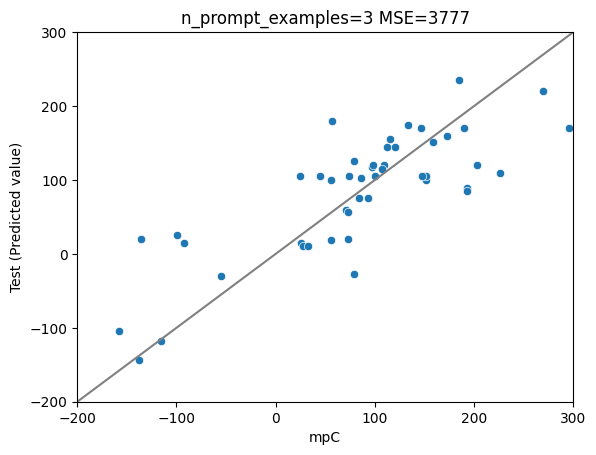

In [21]:
#plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from datetime import datetime
import json
current_datetime = datetime.now()
vmin=-200
vmax=300

#plot prediction results
for n_prompt_examples,records in prediction_results.items():
    sel_df=pd.DataFrame(records)
    #floatに可能なものは変換
    sel_df["Test (Predicted value)"] = pd.to_numeric(sel_df["Test (Predicted value)"], errors='coerce')
    sel_df=sel_df[sel_df["Test (Predicted value)"].notnull()]
    if len(sel_df)==0:
        continue
    mse=mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"])

    plt.figure()
    sns.scatterplot(data=sel_df,x="mpC",y="Test (Predicted value)")
    plt.title(f"n_prompt_examples={n_prompt_examples} MSE={mse:.0f}")

    #x,yの範囲を揃える
    plt.xlim(vmin,vmax)
    plt.ylim(vmin,vmax)
    #対角線を描く
    plt.plot([vmin,vmax],[vmin,vmax],color="gray")
    formatted_filename = f"results/model={model_size}_{current_datetime.strftime('%Y%m%d_%H%M%S')}_train={do_train}.png"
    plt.savefig(formatted_filename)
    #break

save_json_filename=formatted_filename.replace(".png",".json")
with open(save_json_filename,"w") as f:
    json.dump(prediction_results,fp=f,
              indent=4)

In [22]:
#スコア
print(mean_squared_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print(mean_absolute_error(sel_df["mpC"],sel_df["Test (Predicted value)"]))
print(r2_score(sel_df["mpC"],sel_df["Test (Predicted value)"]))


3777.0262500000003
47.025000000000006
0.6584806106384561


In [23]:
#回答可能な問題の割合
sel_df.shape[0]/n_test

0.96